In [4]:
import requests
import pandas as pd
import os
os.makedirs("data", exist_ok=True)

CLIENT_ID = "2a430097-ac9b-44e4-995e-a02afb9795b2"
SOURCE = "SN18700"
BASE_URL = "https://frost.met.no/observations/v0.jsonld"
reference_time = "2024-07-01/2024-12-31"

def fetch_and_save(element_id, label, filename):
    if os.path.exists(filename):
        print("Bruker eksisterende fil:", filename)
        return

    print(f"Henter data for {label.lower()}...")
    params = {
        "sources": SOURCE,
        "elements": element_id,
        "referencetime": reference_time
    }

    response = requests.get(BASE_URL, params=params, auth=(CLIENT_ID, ""))
    if response.status_code == 200:
        data = response.json().get("data", [])
        rows = [(d["referenceTime"].split("T")[0], d["observations"][0]["value"]) for d in data]
        pd.DataFrame(rows, columns=["Dato", label]).to_csv(filename, index=False, encoding="utf-8")
        print(f"{label} lagret som: {filename}")
    else:
        print(f"Feil ved henting av {label.lower()}: {response.status_code}\n{response.text}")

# Hent begge datasett
fetch_and_save("mean(relative_humidity P1D)", "Relativ fuktighet (%)", "data/luftfuktighet_daglig_2024.csv")
fetch_and_save("mean(cloud_area_fraction P1D)", "Skydekke (oktas)", "data/skydekke_daglig_2024.csv")

Henter data for relativ fuktighet (%)...
Relativ fuktighet (%) lagret som: data/luftfuktighet_daglig_2024.csv
Henter data for skydekke (oktas)...
Skydekke (oktas) lagret som: data/skydekke_daglig_2024.csv


In [10]:
import pandas as pd

# Les inn filene (fra data-mappen)
df_gj = pd.read_csv("data/frost_air_temperature_daglig_gjennomsnitt.csv")
df_trykk = pd.read_csv("data/frost_meanair_pressure_at_sea_level_P1D_jul-des_2024.csv")
df_nedbør = pd.read_csv("data/frost_sumprecipitation_amount_P1D_jul-des_2024.csv")
df_luftfukt = pd.read_csv("data/luftfuktighet_daglig_2024.csv")
df_skydekke = pd.read_csv("data/skydekke_daglig_2024.csv")

# Slå sammen alle datasettene på "Dato"
samlet = df_gj \
    .merge(df_trykk, on="Dato", how="left") \
    .merge(df_nedbør, on="Dato", how="left")\
    .merge(df_luftfukt, on="Dato", how="left")\
    .merge(df_skydekke, on="Dato", how="left")

# Rydd opp i kolonnenavn hvis nødvendig
samlet.rename(columns={
    "Temperatur (°C)": "Temperatur (°C) daglig snitt"
}, inplace=True)

# Lagre til fil med nytt navn
samlet.to_csv("data/samling_data_m_LuftFukt.csv", index=False)

# Forhåndsvisning
print(samlet.head())


         Dato  Temperatur (°C) daglig snitt  Lufttrykk (hPa)  Nedbør (mm)  \
0  2024-07-01                     10.393750           1003.0          8.0   
1  2024-07-02                     10.177778           1002.9          3.6   
2  2024-07-03                     11.973611           1000.5          2.0   
3  2024-07-04                     15.785417            993.2          0.1   
4  2024-07-05                     12.113889            991.8          7.7   

   Relativ fuktighet (%)  Skydekke (oktas)  
0                     67               4.7  
1                     62               7.7  
2                     65               7.0  
3                     91               7.7  
4                     79               6.7  


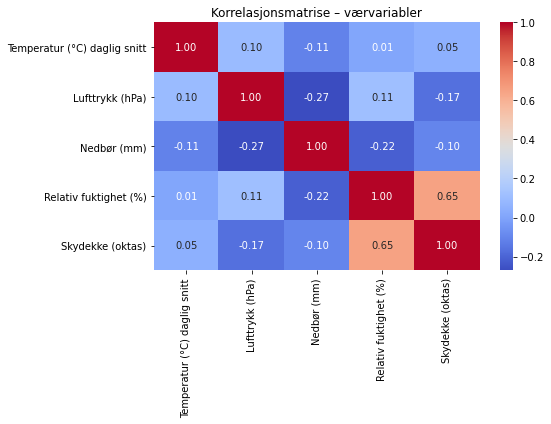

In [15]:
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

korr_data = samlet.drop(columns=["Dato"])  # fjerner dato før korrelasjon
korr = korr_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(korr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelasjonsmatrise – værvariabler")
plt.tight_layout()
plt.show()


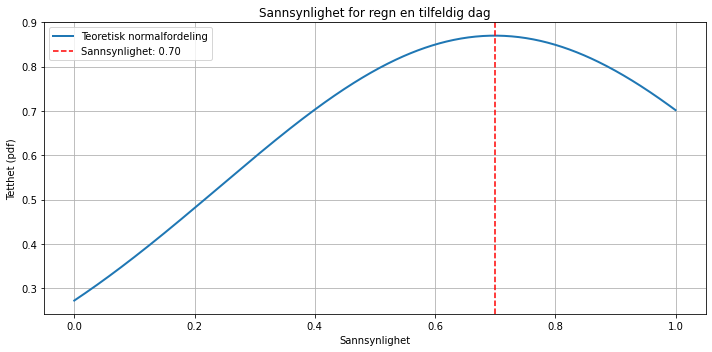

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
#En glatt kurve som viser fordelingen av sannsynlighet for regn
#En rød strek der din faktiske sannsynlighet fra datasettet ligger

# Lag binær kolonne: regndag = 1, ellers 0
samlet["Regn"] = (samlet["Nedbør (mm)"] > 0).astype(int)

# Sannsynlighet og standardavvik
p = samlet["Regn"].mean()
std = np.sqrt(p * (1 - p))

# x-verdier og normalfordelingskurve
x = np.linspace(0, 1, 500)
y = norm.pdf(x, loc=p, scale=std)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="Teoretisk normalfordeling", linewidth=2)
plt.axvline(p, color="red", linestyle="--", label=f"Sannsynlighet: {p:.2f}")

plt.title("Sannsynlighet for regn en tilfeldig dag")
plt.xlabel("Sannsynlighet")
plt.ylabel("Tetthet (pdf)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

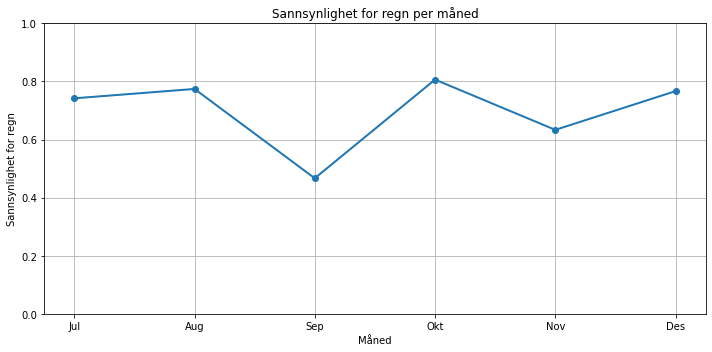

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Sørg for at Dato er datetime
samlet["Dato"] = pd.to_datetime(samlet["Dato"])

# Lag regn-kolonne: 1 hvis nedbør > 0
samlet["Regn"] = (samlet["Nedbør (mm)"] > 0).astype(int)

# Hent måned fra dato
samlet["Måned"] = samlet["Dato"].dt.month

# Gruppér og beregn sannsynlighet (gjennomsnitt) for regn
regn_per_mnd = samlet.groupby("Måned")["Regn"].mean()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(regn_per_mnd.index, regn_per_mnd.values, marker='o', linewidth=2)

plt.xticks(ticks=regn_per_mnd.index, labels=[
    "Jul", "Aug", "Sep", "Okt", "Nov", "Des"
])
plt.ylim(0, 1)
plt.title("Sannsynlighet for regn per måned")
plt.xlabel("Måned")
plt.ylabel("Sannsynlighet for regn")
plt.grid(True)
plt.tight_layout()
plt.show()


Sjekker om lufttrykk er normalfordelt

In [19]:
#SJEKKER OM LUFTTRYKK ER NORMALFORDELT
from scipy.stats import shapiro, normaltest
trykk = samlet["Lufttrykk (hPa)"].dropna()
# Shapiro-Wilk test (bra for <5000 datapunkter)
shapiro_stat, shapiro_p = shapiro(trykk)

# D’Agostino and Pearson’s test
dag_stat, dag_p = normaltest(trykk)

print(f"Shapiro-Wilk p-verdi: {shapiro_p:.4f}")
print(f"D’Agostino K² p-verdi: {dag_p:.4f}")

Shapiro-Wilk p-verdi: 0.6178
D’Agostino K² p-verdi: 0.4344


p > 0.05	Vi kan ikke avvise at dataene er normalfordelt → dataene kan være normalfordelte \
p < 0.05	Vi avviser normalfordeling → dataene er mest sannsynlig ikke normalfordelte

In [ ]:
from scipy.stats import ttest_ind

regn = samlet[samlet["Regn"] == 1]["Lufttrykk (hPa)"]
tørt = samlet[samlet["Regn"] == 0]["Lufttrykk (hPa)"]

t_stat, p_val = ttest_ind(regn, tørt)
print(f"T-test p-verdi: {p_val:.4f}")

#FORKLARING
#En p-verdi < 0.05 betyr at forskjellen er statistisk signifikant.
#p = 0.0000 (veldig lav): ➜ Det er en tydelig forskjell i lufttrykk mellom regndager og tørre dager.

#Hva betyr det i praksis?
#Lufttrykket er systematisk lavere når det regner sammenlignet med dager uten regn i datasettet ditt.
#Dette støtter meteorologisk teori:
#Lavtrykk = mer ustabilt vær → større sjanse for nedbør.



T-test p-verdi: 0.0000



# Videre begrunnelse for dette vises i plottet under

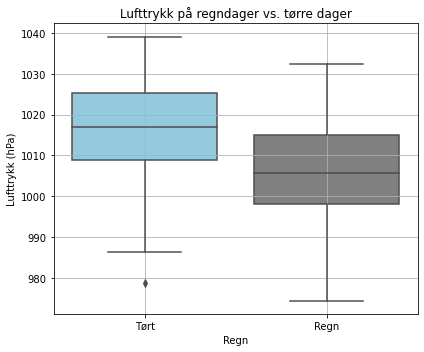

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.boxplot(data=samlet, x="Regn", y="Lufttrykk (hPa)", palette=["skyblue", "gray"])
plt.xticks([0, 1], ["Tørt", "Regn"])
plt.title("Lufttrykk på regndager vs. tørre dager")
plt.ylabel("Lufttrykk (hPa)")
plt.grid(True)
plt.tight_layout()
plt.show()

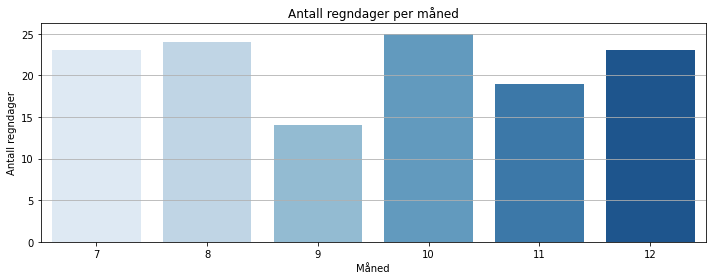

In [22]:
samlet["Måned"] = samlet["Dato"].dt.month
regndager_per_mnd = samlet.groupby("Måned")["Regn"].sum().reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(data=regndager_per_mnd, x="Måned", y="Regn", palette="Blues")
plt.title("Antall regndager per måned")
plt.xlabel("Måned")
plt.ylabel("Antall regndager")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()



# Maskinlæringsmodell:

In [24]:
import matplotlib.pyplot as plt

# Lag figur og to y-akser
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Rens data
df = samlet.dropna(subset=["Temperatur (°C) daglig snitt", "Lufttrykk (hPa)", "Relativ fuktighet (%)"])
X = df[["Lufttrykk (hPa)", "Relativ fuktighet (%)", "Skydekke (oktas)", "Måned"]]

y = df["Temperatur (°C) daglig snitt"]

# Splitte data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell
modell = LinearRegression()
modell.fit(X_train, y_train)
y_pred = modell.predict(X_test)

# Evaluering
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

R²: 0.7468841179287398
RMSE: 3.654965659286138


# Tester modellen:
Visualiser prediksjon vs. faktisk temperatur

R² = 0.75 (ca.)
Modellen forklarer ca. 75 % av variasjonen i daglig temperatur.\
➜ Det betyr at trykk, fuktighet, skydekke og måned gir en sterk forklaringskraft.

RMSE ≈ 3.65°C
Dette er gjennomsnittlig avvik mellom predikert og faktisk temperatur.\
Det er fortsatt litt høyere enn ønskelig (ideelt < 2–3°C), men akseptabelt gitt begrenset datagrunnlag.


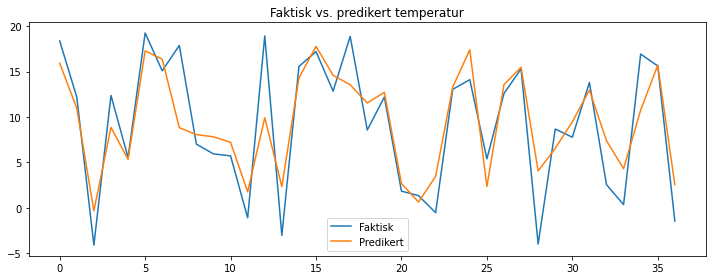

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label="Faktisk")
plt.plot(y_pred, label="Predikert")
plt.title("Faktisk vs. predikert temperatur")
plt.legend()
plt.tight_layout()
plt.show()